In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d
from copy import deepcopy
import seaborn as sns

In [9]:
df = pd.read_csv("../data/experiment_2_hyperparameters.csv")
df.head()

,Step,Reward,Run,Configuration,Hyperparameter,Hyperparameter Value
0,1,-2.725875,1,Epsilon Greedy: ε=0.0078125,epsilon,0.007812
1,2,-0.279455,1,Epsilon Greedy: ε=0.0078125,epsilon,0.007812
2,3,-0.100122,1,Epsilon Greedy: ε=0.0078125,epsilon,0.007812
3,4,-0.841474,1,Epsilon Greedy: ε=0.0078125,epsilon,0.007812
4,5,0.235202,1,Epsilon Greedy: ε=0.0078125,epsilon,0.007812


In [3]:
df["Algorithm"] = df["Configuration"].apply(lambda x: x.split(":")[0])
df.drop(["Configuration", "Hyperparameter"], axis=1, inplace=True)
df.head()

,Step,Reward,Run,Hyperparameter Value,Algorithm
0,1,-2.725875,1,0.007812,Epsilon Greedy
1,2,-0.279455,1,0.007812,Epsilon Greedy
2,3,-0.100122,1,0.007812,Epsilon Greedy
3,4,-0.841474,1,0.007812,Epsilon Greedy
4,5,0.235202,1,0.007812,Epsilon Greedy


In [4]:
df["Reward"] = df.groupby(["Run", "Algorithm", "Hyperparameter Value"])[
    "Reward"
].transform(lambda x: uniform_filter1d(x, size=5, mode="nearest"))

grouped = (
    df.groupby(["Run", "Algorithm", "Hyperparameter Value"])["Reward"]
    .agg(["mean", "std"])
    .reset_index()
)

In [5]:
grouped

,Run,Algorithm,Hyperparameter Value,mean,std
0,1,Action Preference,0.03125,1.536687,0.738549
1,1,Action Preference,0.06250,2.327467,0.713406
2,1,Action Preference,0.12500,1.246064,0.520711
3,1,Action Preference,0.25000,0.692468,0.499830
4,1,Action Preference,0.50000,1.304456,0.473885
...,...,...,...,...,...
14495,500,UCB,0.25000,1.649286,0.449401
14496,500,UCB,0.50000,1.420340,0.500811
14497,500,UCB,1.00000,2.631568,0.478907
14498,500,UCB,2.00000,0.019213,0.552331


In [6]:
grouped = (
    grouped.groupby(["Algorithm", "Hyperparameter Value"])[["mean", "std"]]
    .agg(["mean"])
    .reset_index()
)

# Flatten column names after aggregation
grouped.columns = ["Algorithm", "Hyperparameter Value", "mean", "std"]

# Compute the standard error of the mean (SEM)
grouped["sem"] = grouped["std"] / np.sqrt(500)

In [7]:
grouped

,Algorithm,Hyperparameter Value,mean,std,sem
0,Action Preference,0.031250,1.114608,0.703994,0.031484
1,Action Preference,0.062500,1.268598,0.632897,0.028304
2,Action Preference,0.125000,1.363069,0.565054,0.025270
3,Action Preference,0.250000,1.436862,0.519064,0.023213
4,Action Preference,0.500000,1.402387,0.496139,0.022188
5,Action Preference,1.000000,1.270372,0.482708,0.021587
6,Action Preference,2.000000,1.115918,0.477067,0.021335
7,Action Preference,4.000000,0.953497,0.475675,0.021273
8,Epsilon Greedy,0.007812,1.171700,0.509236,0.022774
9,Epsilon Greedy,0.015625,1.251958,0.515878,0.023071


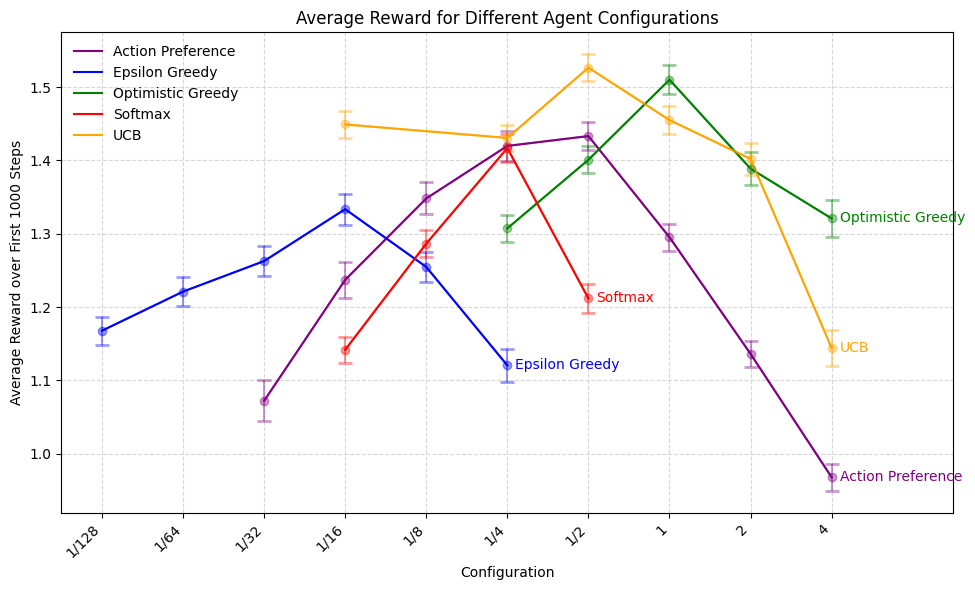

In [38]:
agent_colors = {
    "Epsilon Greedy": "blue",
    "UCB": "orange",
    "Optimistic Greedy": "green",
    "Softmax": "red",
    "Action Preference": "purple",
}

sns.set_palette("Set2")


unique_hyperparameters = np.unique(grouped["Hyperparameter Value"])
x_axis_mapping = {value: i for i, value in enumerate(unique_hyperparameters)}

plt.figure(figsize=(10, 6))

for algorithm in grouped["Algorithm"].unique():
    subset = deepcopy(grouped[grouped["Algorithm"] == algorithm])
    subset["x_mapped"] = subset["Hyperparameter Value"].map(lambda x: x_axis_mapping[x])
    current_color = agent_colors[algorithm]

    plt.plot(
        subset["x_mapped"],
        subset["mean"].to_numpy().flatten(),
        label=algorithm,
        color=current_color,
    )

    plt.errorbar(
        subset["x_mapped"],
        subset["mean"].to_numpy().flatten(),
        yerr=subset["sem"].to_numpy().flatten(),
        fmt="-",
        color=current_color,
        elinewidth=1.5,
        capsize=5,
        capthick=2,
        alpha=0.4,
        markersize=6,
        marker="o",
    )
    x_pos = subset["x_mapped"].iloc[-1]
    y_pos = subset["mean"].iloc[-1]

    plt.text(
        x_pos + 0.1,
        y_pos,
        algorithm,
        fontsize=10,
        verticalalignment="center",
        horizontalalignment="left",
        color=current_color,
    )

x_axis_labels = ["1/128", "1/64", "1/32", "1/16", "1/8", "1/4", "1/2", "1", "2", "4"]
plt.xticks(
    ticks=range(0, len(x_axis_labels), 1), labels=x_axis_labels, rotation=45, ha="right"
)

plt.ylabel("Average Reward over First 1000 Steps")
plt.xlabel("Configuration")
plt.xlim(-0.5, 10.5)
plt.title("Average Reward for Different Agent Configurations")
plt.legend(loc="upper left", fontsize=10, frameon=False)
plt.grid(True, linestyle="--", color="lightgray", alpha=0.9)
plt.tight_layout()
plt.show()

In [8]:
def preprocess_hyperparam_data(
    df: pd.DataFrame = None, num_runs: int = 500
) -> pd.DataFrame:
    """Preprocess the data for the hyperparameter experiment."""
    df["Algorithm"] = df["Configuration"].apply(lambda x: x.split(":")[0])
    df.drop(["Configuration", "Hyperparameter"], axis=1, inplace=True)

    df["Reward"] = df.groupby(["Run", "Algorithm", "Hyperparameter Value"])[
        "Reward"
    ].transform(lambda x: uniform_filter1d(x, size=5, mode="nearest"))

    grouped = (
        df.groupby(["Run", "Algorithm", "Hyperparameter Value"])["Reward"]
        .agg(["mean", "std"])
        .reset_index()
    )

    grouped = (
        grouped.groupby(["Algorithm", "Hyperparameter Value"])[["mean", "std"]]
        .agg(["mean"])
        .reset_index()
    )

    # Flatten column names after aggregation
    grouped.columns = ["Algorithm", "Hyperparameter Value", "mean", "std"]

    # Compute the standard error of the mean (SEM)
    grouped["sem"] = grouped["std"] / np.sqrt(num_runs)

    return grouped

In [10]:
print(preprocess_hyperparam_data(df=df, num_runs=500))

            Algorithm  Hyperparameter Value      mean       std       sem
0   Action Preference              0.031250  1.114608  0.703994  0.031484
1   Action Preference              0.062500  1.268598  0.632897  0.028304
2   Action Preference              0.125000  1.363069  0.565054  0.025270
3   Action Preference              0.250000  1.436862  0.519064  0.023213
4   Action Preference              0.500000  1.402387  0.496139  0.022188
5   Action Preference              1.000000  1.270372  0.482708  0.021587
6   Action Preference              2.000000  1.115918  0.477067  0.021335
7   Action Preference              4.000000  0.953497  0.475675  0.021273
8      Epsilon Greedy              0.007812  1.171700  0.509236  0.022774
9      Epsilon Greedy              0.015625  1.251958  0.515878  0.023071
10     Epsilon Greedy              0.031250  1.324904  0.534157  0.023888
11     Epsilon Greedy              0.062500  1.322396  0.536388  0.023988
12     Epsilon Greedy              0.1